In [3]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.random as rand

from makeCorner import *

az.rcParams["plot.max_subplots"] = 90

In [4]:
# cdf_file = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Redshift_in_Mass_sigmoid/cdf_files_sigmoid//CBC_O3_smaller_priors_on_middle_m_30_75.cdf"
# "./RUNS/CBC_O3_Reverse_Sector.cdf"
cdf_file = "../data/RUNS/my_reverse_sector_logit_for_middle_z_until_75_from_20_seed_110.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

In [ ]:
az.plot_trace(data)
plt.tight_layout()
plt.show()

In [5]:
def sigmoid_zp(low, high, width, middle, mass):
    return (high - low) / (1 + jnp.exp(-(1/width)*(mass - middle))) + low

def sigmoid_delta(low, delta, width, middle, mass):
    return (delta) / (1 + jnp.exp(-(1/width)*(mass - middle))) + low

def merger_rate_zp_sigmoid(alpha_z,high_alpha, width_alpha_z, middle_alpha_z,
                           beta_z, high_beta_z, width_beta_z, middle_beta_z,
                           low_zp, high_zp, width_m, m_middle, masses, z_s):
    alpha_z = sigmoid_zp(alpha_z, high_alpha, width_alpha_z, middle_alpha_z, masses)
    beta_z = sigmoid_zp(beta_z, high_beta_z, width_beta_z, middle_beta_z, masses)
    new_zp = sigmoid_zp(low_zp, high_zp, width_m, m_middle, masses)
    return (1+z_s)**alpha_z/(1+((1+z_s)/(1+new_zp))**(alpha_z+beta_z))

def computing_gaussian_prob(value, mean, std):
    return (1/(std * np.sqrt(2*np.pi))) * np.exp(-(value - mean)**2/(2.*std**2))

def computing_uniform_prob(a, b):
    return 1/(b-a)

m_grid = np.linspace(2,120,500)

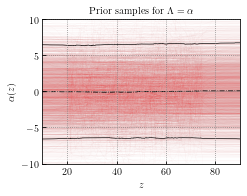

In [6]:
cm = 1/2.54
masses = np.linspace(0,90, 5000)
fig1, ax1 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax1.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_z.size)), len(masses)))

prior_alpha_z = rand.normal(0,4, samps.alpha_ref.size)
prior_high_alpha_z = rand.normal(0, 4, samps.alpha_ref.size)
prior_width_alpha_z = rand.uniform(-1,1, samps.alpha_ref.size)
prior_middle_alpha_z = rand.uniform(20, 75, samps.alpha_ref.size)

for i in range(samps.alpha_ref.size):
    alpha_r = sigmoid_zp(prior_alpha_z[i],
                               prior_high_alpha_z[i],
                               10.**prior_width_alpha_z[i],
                               prior_middle_alpha_z[i],
                               masses,
                              )
    ax1.plot(masses, alpha_r, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r

alpha_median = np.median(alpha_matrix, axis = 0)
plt.xlim(10, 90)
plt.ylim(-10, 10)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\alpha(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
only_prior_alpha_median = alpha_median
only_prior_alpha_quantile_5 = np.quantile(alpha_matrix,0.05,axis=0)
only_prior_alpha_quantile_95 = np.quantile(alpha_matrix,0.95,axis=0)
ax1.plot(masses, only_prior_alpha_median, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,only_prior_alpha_quantile_5, zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,only_prior_alpha_quantile_95, zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"Prior samples for $\Lambda = \alpha$", fontsize = 10)
plt.savefig("Prior_trace_alpha_z.pdf", dpi=400, bbox_inches='tight')
plt.show()

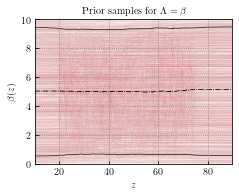

In [7]:
cm = 1/2.54
masses = np.linspace(0,90, 5000)
fig1, ax1 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax1.set_rasterization_zorder(2)
beta_matrix = np.zeros((len(range(samps.beta_z.size)), len(masses)))

prior_beta_z = rand.uniform(0,10, samps.beta_z.size)
prior_high_beta_z = rand.uniform(0, 10, samps.beta_z.size)
prior_width_beta_z = rand.uniform(-1,1, samps.beta_z.size)
prior_middle_beta_z = rand.uniform(20, 75, samps.beta_z.size)

for i in range(samps.beta_z.size):
    beta_r = sigmoid_zp(prior_beta_z[i],
                               prior_high_beta_z[i],
                               10.**prior_width_beta_z[i],
                               prior_middle_beta_z[i],
                               masses,
                              )
    ax1.plot(masses, beta_r, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    beta_matrix[i, :] = beta_r

beta_median = np.median(beta_matrix, axis = 0)
plt.xlim(10, 90)
plt.ylim(0, 10)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\beta(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
only_prior_beta_median = beta_median
only_prior_beta_quantile_5 = np.quantile(beta_matrix,0.05,axis=0)
only_prior_beta_quantile_95 = np.quantile(beta_matrix,0.95,axis=0)
ax1.plot(masses, only_prior_beta_median, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,only_prior_beta_quantile_5, zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,only_prior_beta_quantile_95, zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"Prior samples for $\Lambda = \beta$", fontsize = 10)
plt.savefig("Prior_trace_beta_z.pdf", dpi=400, bbox_inches='tight')
plt.show()

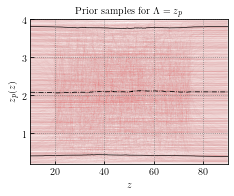

In [8]:
cm = 1/2.54
masses = np.linspace(0,90, 5000)
fig1, ax1 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax1.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_z.size)), len(masses)))

prior_zp_z = rand.uniform(0.2,4, samps.alpha_ref.size)
prior_high_zp_z = rand.uniform(0.2, 4, samps.alpha_ref.size)
prior_width_zp_z = rand.uniform(-1,1, samps.alpha_ref.size)
prior_middle_zp_z = rand.uniform(20, 75, samps.alpha_ref.size)

for i in range(samps.alpha_ref.size):
    zp_r = sigmoid_zp(prior_zp_z[i],
                               prior_high_zp_z[i],
                               10.**prior_width_zp_z[i],
                               prior_middle_zp_z[i],
                               masses,
                              )
    ax1.plot(masses, zp_r, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    zp_matrix[i, :] = zp_r

zp_median = np.median(zp_matrix, axis = 0)
plt.xlim(10, 90)
plt.ylim(0.2, 4)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$z_p(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
only_prior_zp_median = zp_median
only_prior_zp_quantile_5 = np.quantile(zp_matrix,0.05,axis=0)
only_prior_zp_quantile_95 = np.quantile(zp_matrix,0.95,axis=0)
ax1.plot(masses, only_prior_zp_median, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,only_prior_zp_quantile_5, zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,only_prior_zp_quantile_95, zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"Prior samples for $\Lambda = z_p$", fontsize = 10)
plt.savefig("Prior_trace_zp_z.pdf", dpi=400, bbox_inches='tight')
plt.show()

In [9]:
error_tol = 1e-2
npts = np.size(samps.alpha_z.values)
brute_force_alpha_z_high = np.zeros(npts)
brute_force_alpha_z_low = np.zeros(npts)
brute_force_m_transition = np.zeros(npts)
brute_force_delta_m = np.zeros(npts)
m_ref = 35

for i in range(npts):
    
    close_enough = False
    posterior_value_m_35 = sigmoid_zp(
        samps.alpha_z.values[i],
        samps.high_alpha_z.values[i],
        10.**samps.log_width_alpha_z.values[i],
        samps.middle_m_alpha_z.values[i],
        m_ref,
    )
    
    while not close_enough:
        
        # Draw a random set of hyperparameters from their original priors
        draw_alpha_z_low = np.random.normal(loc=0,scale=4)
        draw_alpha_z_high = np.random.normal(loc=0,scale=4)
        draw_m_transition = np.random.uniform(low=20,high=75)
        draw_log_delta_m = np.random.uniform(low=-1,high=1)
        draw_delta_m = 10.**draw_log_delta_m
        
        # Compute the sigmoid defined by these parameters and evaluate it at m_ref = 35
        sig_val = sigmoid_zp(draw_alpha_z_low, draw_alpha_z_high, draw_delta_m, draw_m_transition, m_ref)
        if np.abs(sig_val-posterior_value_m_35)<error_tol:
            
            # If we're sufficiently close to the target, save
            brute_force_alpha_z_high[i] = draw_alpha_z_high
            brute_force_alpha_z_low[i] = draw_alpha_z_low
            brute_force_m_transition[i] = draw_m_transition
            brute_force_delta_m[i] = draw_delta_m
            
            close_enough = True

In [10]:
error_tol = 1e-2
npts = np.size(samps.alpha_z.values)
brute_force_zp_high = np.zeros(npts)
brute_force_zp_low = np.zeros(npts)
brute_force_m_transition_zp = np.zeros(npts)
brute_force_delta_m_zp = np.zeros(npts)
m_ref = 35

for i in range(npts):
    
    close_enough = False
    posterior_value_m_35 = sigmoid_zp(
        samps.low_zp.values[i],
        samps.high_zp.values[i],
        10.**samps.log_width_zp.values[i],
        samps.middle_m_zp.values[i],
        m_ref,
    )
    
    while not close_enough:
        
        # Draw a random set of hyperparameters from their original priors
        draw_zp_low = np.random.uniform(low=0.2,high=4)
        draw_zp_high = np.random.uniform(low=0.2,high=4)
        draw_m_transition = np.random.uniform(low=20,high=75)
        draw_log_delta_m = np.random.uniform(low=-1,high=1)
        draw_delta_m = 10.**draw_log_delta_m
        
        # Compute the sigmoid defined by these parameters and evaluate it at m_ref = 35
        sig_val = sigmoid_zp(draw_zp_low, draw_zp_high, draw_delta_m, draw_m_transition, m_ref)
        if np.abs(sig_val-posterior_value_m_35)<error_tol:
            
            # If we're sufficiently close to the target, save
            brute_force_zp_high[i] = draw_zp_high
            brute_force_zp_low[i] = draw_zp_low
            brute_force_m_transition_zp[i] = draw_m_transition
            brute_force_delta_m_zp[i] = draw_delta_m
            
            close_enough = True

In [11]:
error_tol = 1e-2
npts = np.size(samps.alpha_z.values)
brute_force_beta_high = np.zeros(npts)
brute_force_beta_low = np.zeros(npts)
brute_force_m_transition_beta = np.zeros(npts)
brute_force_delta_m_beta = np.zeros(npts)
m_ref = 35

for i in range(npts):
    
    close_enough = False
    posterior_value_m_35 = sigmoid_zp(
        samps.beta_z.values[i],
        samps.high_beta_z.values[i],
        10.**samps.log_width_beta_z.values[i],
        samps.middle_m_beta_z.values[i],
        m_ref,
    )
    
    while not close_enough:
        
        # Draw a random set of hyperparameters from their original priors
        draw_beta_low = np.random.uniform(low=0,high=10)
        draw_beta_high = np.random.uniform(low=0,high=10)
        draw_m_transition = np.random.uniform(low=20,high=75)
        draw_log_delta_m = np.random.uniform(low=-1,high=1)
        draw_delta_m = 10.**draw_log_delta_m
        
        # Compute the sigmoid defined by these parameters and evaluate it at m_ref = 35
        sig_val = sigmoid_zp(draw_beta_low, draw_beta_high, draw_delta_m, draw_m_transition, m_ref)
        if np.abs(sig_val-posterior_value_m_35)<error_tol:
            
            # If we're sufficiently close to the target, save
            brute_force_beta_high[i] = draw_beta_high
            brute_force_beta_low[i] = draw_beta_low
            brute_force_m_transition_beta[i] = draw_m_transition
            brute_force_delta_m_beta[i] = draw_delta_m
            
            close_enough = True

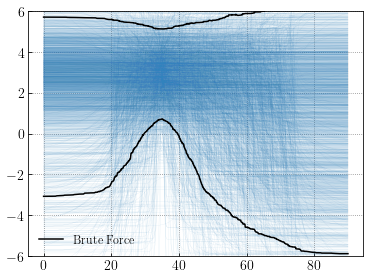

In [12]:
brute_force_conditional_prior = np.array([sigmoid_zp(brute_force_alpha_z_low[i], brute_force_alpha_z_high[i], brute_force_delta_m[i], brute_force_m_transition[i], masses) 
                           for i in range(npts)])

# Plot
fig,ax = plt.subplots()
for i in range(npts):
    ax.plot(masses, brute_force_conditional_prior[i,:], color='#3182bd', lw=0.2, alpha=0.2)
    
ax.plot(masses, np.quantile(brute_force_conditional_prior, 0.05, axis=0), color='black', label='Brute Force')
ax.plot(masses, np.quantile(brute_force_conditional_prior, 0.95, axis=0), color='black')
# ax.plot(masses, np.nanquantile(alpha_matrix, 0.05, axis=0), color='black', ls=':')
# ax.plot(masses, np.nanquantile(alpha_matrix, 0.95, axis=0), color='black', ls=':', label='Old Strategy')

ax.set_ylim(-6,6)
ax.legend(loc='lower left',fontsize=12)
plt.savefig("brute_force_vs_old.pdf", dpi = 500)
plt.show()

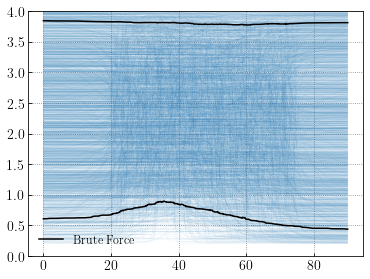

In [13]:
brute_force_conditional_prior_zp = np.array([sigmoid_zp(brute_force_zp_low[i], brute_force_zp_high[i], brute_force_delta_m_zp[i], brute_force_m_transition_zp[i], masses) 
                           for i in range(npts)])

# Plot
fig,ax = plt.subplots()
for i in range(npts):
    ax.plot(masses, brute_force_conditional_prior_zp[i,:], color='#3182bd', lw=0.2, alpha=0.2)
    
ax.plot(masses, np.quantile(brute_force_conditional_prior_zp, 0.05, axis=0), color='black', label='Brute Force')
ax.plot(masses, np.quantile(brute_force_conditional_prior_zp, 0.95, axis=0), color='black')
# ax.plot(masses, np.nanquantile(alpha_matrix, 0.05, axis=0), color='black', ls=':')
# ax.plot(masses, np.nanquantile(alpha_matrix, 0.95, axis=0), color='black', ls=':', label='Old Strategy')

ax.set_ylim(0,4)
ax.legend(loc='lower left',fontsize=12)
plt.savefig("brute_force_vs_old_zp.pdf", dpi = 500)
plt.show()

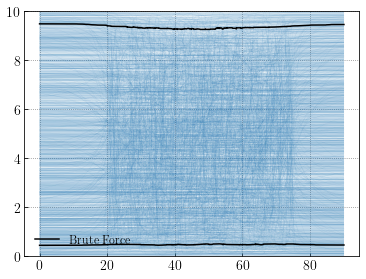

In [14]:
brute_force_conditional_prior_beta = np.array([sigmoid_zp(brute_force_beta_low[i], brute_force_beta_high[i], brute_force_delta_m_beta[i], brute_force_m_transition_beta[i], masses) 
                           for i in range(npts)])

# Plot
fig,ax = plt.subplots()
for i in range(npts):
    ax.plot(masses, brute_force_conditional_prior_beta[i,:], color='#3182bd', lw=0.2, alpha=0.2)
    
ax.plot(masses, np.quantile(brute_force_conditional_prior_beta, 0.05, axis=0), color='black', label='Brute Force')
ax.plot(masses, np.quantile(brute_force_conditional_prior_beta, 0.95, axis=0), color='black')
# ax.plot(masses, np.nanquantile(alpha_matrix, 0.05, axis=0), color='black', ls=':')
# ax.plot(masses, np.nanquantile(alpha_matrix, 0.95, axis=0), color='black', ls=':', label='Old Strategy')

ax.set_ylim(0,10)
ax.legend(loc='lower left',fontsize=12)
plt.savefig("brute_force_vs_old_beta.pdf", dpi = 500)
plt.show()

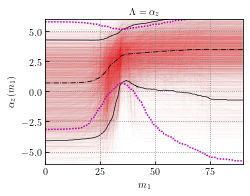

In [21]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
m_ref = 35

for i in range(samps.alpha_z.size):
    alpha_r_post = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               masses,
                              )
    plt.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha_post = np.median(alpha_matrix_post, axis = 0)
plt.xlim(0,90)
plt.ylim(-6, 6)
plt.xlabel(r"$m_1$", fontsize = 10)
plt.ylabel(r"$\alpha_z(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(masses, np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, np.quantile(brute_force_conditional_prior, 0.05, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
plt.plot(masses, np.quantile(brute_force_conditional_prior, 0.95, axis=0), zorder = 1,color='m',  linestyle=(0,(1,1)))
plt.plot(masses, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \alpha_z$", fontsize = 10)
plt.savefig("Bruteforce_cond_prior_at_m_35_alpha_z.png", dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_967492/2356245640.py:32: RuntimeWarning: invalid value encountered in double_scalars
  rejection_param = prob_low_prior / exp_inv / C
/tmp/ipykernel_967492/2356245640.py:32: RuntimeWarning: invalid value encountered in double_scalars
  rejection_param = prob_low_prior / exp_inv / C
/tmp/ipykernel_967492/2356245640.py:32: RuntimeWarning: invalid value encountered in double_scalars
  rejection_param = prob_low_prior / exp_inv / C
/tmp/ipykernel_967492/2356245640.py:32: RuntimeWarning: invalid value encountered in double_scalars
  rejection_param = prob_low_prior / exp_inv / C
/tmp/ipykernel_967492/2356245640.py:32: RuntimeWarning: invalid value encountered in double_scalars
  rejection_param = prob_low_prior / exp_inv / C
/tmp/ipykernel_967492/2356245640.py:32: RuntimeWarning: invalid value encountered in double_scalars
  rejection_param = prob_low_prior / exp_inv / C
/tmp/ipykernel_967492/2356245640.py:32: RuntimeWarning: invalid value encountered in double_scalars
  reje

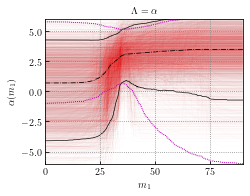

In [85]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
m_ref = 35

for i in range(samps.alpha_z.size):
    okay = False
    while not okay:
        prior_alpha = rand.normal(0, 4)
        prior_high_alpha = rand.normal(0, 4)
        prior_width_alpha = rand.uniform(-1,1)
        prior_middle_alpha = rand.uniform(20, 75)
        posterior_value_z_0 = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               35,
                              )
        intermediate_step = 1 + np.exp(-(m_ref - samps.middle_m_alpha_z.values[i])/samps.width_alpha_z.values[i])
        value_at_z_0 = samps.alpha_z.values[i] + (
            (samps.high_alpha_z.values[i] - samps.alpha_z.values[i])/(intermediate_step)
        )
        intermediate_step_prior = np.exp(-(m_ref - prior_middle_alpha)/(10**(prior_width_alpha)))
        low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
        
        prob_low_prior = computing_gaussian_prob(low_z_value_alpha, 0, 4)
        exp_inv = 1 - (1/(1 + np.exp(-(m_ref - prior_middle_alpha)/(10.**(prior_width_alpha)))))
        C = 1 # 1e4
        rejection_param = prob_low_prior / exp_inv / C
    
        rejection_threshold = rand.uniform(0, 1)

        if rejection_threshold <= rejection_param:
            okay = True
        
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    alpha_r_post = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               masses,
                              )
    plt.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
plt.xlim(0,90)
plt.ylim(-6, 6)
plt.xlabel(r"$m_1$", fontsize = 10)
plt.ylabel(r"$\alpha(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
# plt.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
# plt.plot(masses, only_prior_alpha_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \alpha$", fontsize = 10)
plt.savefig("Prior_random_tuning_to_posterior_at_m_0_alpha_z.pdf", dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2204615/4249641565.py:22: RuntimeWarning: overflow encountered in exp
  intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
/tmp/ipykernel_2204615/4249641565.py:23: RuntimeWarning: invalid value encountered in double_scalars
  low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
/tmp/ipykernel_2204615/4249641565.py:18: RuntimeWarning: overflow encountered in exp
  intermediate_step = 1 + np.exp(samps.middle_m_beta_z.values[i]/samps.width_beta_z.values[i])


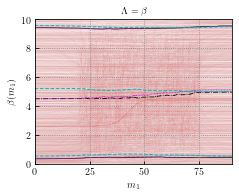

In [75]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.beta_z.size):
    prior_alpha = rand.uniform(0, 10)
    prior_high_alpha = rand.uniform(0, 10)
    prior_width_alpha = rand.uniform(-1,1)
    prior_middle_alpha = rand.uniform(20, 75)
    posterior_value_z_0 = sigmoid_zp(samps.beta_z.values[i],
                               samps.high_beta_z.values[i],
                               10.**samps.log_width_beta_z.values[i],
                               samps.middle_m_beta_z.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_beta_z.values[i]/samps.width_beta_z.values[i])
    value_at_z_0 = samps.beta_z.values[i] + (
        (samps.high_beta_z.values[i] - samps.beta_z.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
    low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_alpha
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    
    alpha_r_post = sigmoid_zp(samps.beta_z.values[i],
                               samps.high_beta_z.values[i],
                               10.**samps.log_width_beta_z.values[i],
                               samps.middle_m_beta_z.values[i],
                               masses,
                              )
    plt.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
plt.xlim(0,90)
plt.ylim(0, 10)
plt.xlabel(r"$m_1$", fontsize = 10)
plt.ylabel(r"$\beta(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses, only_prior_beta_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_beta_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_beta_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \beta$", fontsize = 10)
plt.savefig("Prior_random_tuning_to_posterior_at_m_0_beta_z.pdf", dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2204615/3803724664.py:22: RuntimeWarning: overflow encountered in exp
  intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
/tmp/ipykernel_2204615/3803724664.py:23: RuntimeWarning: invalid value encountered in double_scalars
  low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
/tmp/ipykernel_2204615/3803724664.py:18: RuntimeWarning: overflow encountered in exp
  intermediate_step = 1 + np.exp(samps.middle_m_zp.values[i]/samps.width_zp.values[i])


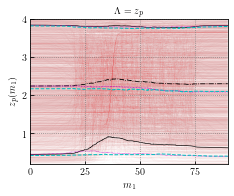

In [76]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.low_zp.size):
    prior_alpha = rand.uniform(0.2, 4)
    prior_high_alpha = rand.uniform(0.2, 4)
    prior_width_alpha = rand.uniform(-1,1)
    prior_middle_alpha = rand.uniform(20, 75)
    posterior_value_z_0 = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_zp.values[i]/samps.width_zp.values[i])
    value_at_z_0 = samps.low_zp.values[i] + (
        (samps.high_zp.values[i] - samps.low_zp.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
    low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_alpha
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    
    alpha_r_post = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               masses,
                              )
    plt.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
plt.xlim(0,90)
plt.ylim(0.2, 4)
plt.xlabel(r"$m_1$", fontsize = 10)
plt.ylabel(r"$z_p(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses, only_prior_zp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_zp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_zp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = z_p$", fontsize = 10)
plt.savefig("Prior_random_tuning_to_posterior_at_m_0_zp.pdf", dpi=500, bbox_inches='tight')
plt.show()

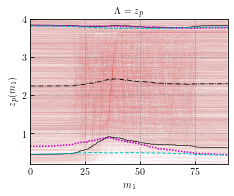

In [27]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
zp_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
m_ref = 35

for i in range(samps.alpha_z.size):
    zp_r_post = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               masses,
                              )
    plt.plot(masses, zp_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    zp_matrix_post[i, :] = zp_r_post

median_zp_post = np.median(zp_matrix_post, axis = 0)
plt.xlim(0,90)
plt.ylim(0.2, 4)
plt.xlabel(r"$m_1$", fontsize = 10)
plt.ylabel(r"$z_p(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(masses, median_zp_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(masses, np.quantile(zp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, np.quantile(zp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, np.quantile(brute_force_conditional_prior_zp, 0.05, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
plt.plot(masses, np.quantile(brute_force_conditional_prior_zp, 0.95, axis=0), zorder = 1,color='m',  linestyle=(0,(1,1)))
plt.plot(masses, only_prior_zp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_zp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = z_p$", fontsize = 10)
plt.savefig("Bruteforce_cond_prior_at_m_35_zp_z.png", dpi=500, bbox_inches='tight')
plt.show()

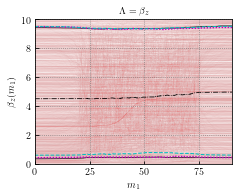

In [29]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
beta_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
beta_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
m_ref = 35

for i in range(samps.alpha_z.size):
    beta_r_post = sigmoid_zp(samps.beta_z.values[i],
                               samps.high_beta_z.values[i],
                               10.**samps.log_width_beta_z.values[i],
                               samps.middle_m_beta_z.values[i],
                               masses,
                              )
    plt.plot(masses, beta_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    beta_matrix_post[i, :] = beta_r_post

median_beta_post = np.median(beta_matrix_post, axis = 0)
plt.xlim(0,90)
plt.ylim(0, 10)
plt.xlabel(r"$m_1$", fontsize = 10)
plt.ylabel(r"$\beta_z(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(masses, median_beta_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(masses, np.quantile(beta_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, np.quantile(beta_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, np.quantile(brute_force_conditional_prior_beta, 0.05, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
plt.plot(masses, np.quantile(brute_force_conditional_prior_beta, 0.95, axis=0), zorder = 1,color='m',  linestyle=(0,(1,1)))
plt.plot(masses, only_prior_beta_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_beta_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \beta_z$", fontsize = 10)
plt.savefig("Bruteforce_cond_prior_at_m_35_beta_z.png", dpi=500, bbox_inches='tight')
plt.show()

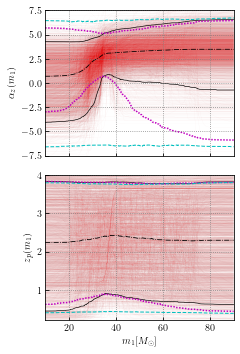

In [16]:
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8.75*cm, 2*6.375*cm))

ax1.set_rasterization_zorder(2)

alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.alpha_z.size):    
    alpha_r_post = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               masses,
                              )
    ax1.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
ax1.set_ylim(-7.5, 7.5)
ax1.set_ylabel(r"$\alpha_z(m_1)$", fontsize = 10)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses, np.quantile(brute_force_conditional_prior, 0.05, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
ax1.plot(masses, np.quantile(brute_force_conditional_prior, 0.95, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
ax1.plot(masses, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


ax2.set_rasterization_zorder(2)
zp_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.low_zp.size):    
    zp_r_post = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               masses,
                              )
    plt.plot(masses, zp_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    zp_matrix_post[i, :] = zp_r_post

median_zp = np.nanmedian(zp_matrix, axis = 0)
median_zp_post = np.median(zp_matrix_post, axis = 0)
ax2.set_xlim(10,90)
ax2.set_ylim(0.2, 4)
ax2.set_xlabel(r"$m_1 [M_\odot]$", fontsize = 10)
ax2.set_ylabel(r"$z_p(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax2.plot(masses, median_zp_post, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(masses,np.quantile(zp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses,np.quantile(zp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses, np.quantile(brute_force_conditional_prior_zp, 0.05, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
ax2.plot(masses, np.quantile(brute_force_conditional_prior_zp, 0.95, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
ax2.plot(masses, only_prior_zp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

plt.setp(ax1.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("Reverse_conditional_plot_slides.pdf", dpi=500, bbox_inches="tight")
plt.show()

/tmp/ipykernel_967492/2937039318.py:23: RuntimeWarning: overflow encountered in exp
  intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
/tmp/ipykernel_967492/2937039318.py:24: RuntimeWarning: invalid value encountered in double_scalars
  low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
/tmp/ipykernel_967492/2937039318.py:23: RuntimeWarning: overflow encountered in exp
  intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
/tmp/ipykernel_967492/2937039318.py:24: RuntimeWarning: invalid value encountered in double_scalars
  low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
/tmp/ipykernel_967492/2937039318.py:19: RuntimeWarning: overflow encountered in exp
  intermediate_step = 1 + np.exp(samps.middle_m_alpha_z.values[i]/samps.width_alpha_z.values[i])
/tmp/ipykernel_967492/2937039318.py:23: RuntimeWarn

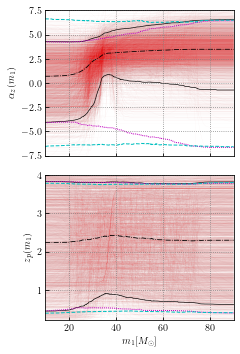

In [65]:
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8.75*cm, 2*6.375*cm))

ax1.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.alpha_z.size):
    prior_alpha = rand.normal(0, 4)
    prior_high_alpha = rand.normal(0, 4)
    prior_width_alpha = rand.uniform(-1,1)
    prior_middle_alpha = rand.uniform(20, 75)
    posterior_value_z_0 = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_alpha_z.values[i]/samps.width_alpha_z.values[i])
    value_at_z_0 = samps.alpha_z.values[i] + (
        (samps.high_alpha_z.values[i] - samps.alpha_z.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
    low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_alpha
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    
    alpha_r_post = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               masses,
                              )
    ax1.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
ax1.set_ylim(-7.5, 7.5)
ax1.set_ylabel(r"$\alpha_z(m_1)$", fontsize = 10)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
# ax1.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax1.plot(masses,np.nanquantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
ax1.plot(masses,np.nanquantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
# ax1.plot(masses, only_prior_alpha_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


ax2.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
zp_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.low_zp.size):
    prior_zp = rand.uniform(0.2, 4)
    prior_high_zp = rand.uniform(0.2, 4)
    prior_width_zp = rand.uniform(-1,1)
    prior_middle_zp = rand.uniform(20, 75)
    posterior_value_z_0 = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_zp.values[i]/samps.width_zp.values[i])
    value_at_z_0 = samps.low_zp.values[i] + (
        (samps.high_zp.values[i] - samps.low_zp.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_zp/(10**(prior_width_zp)))
    low_z_value_zp = (prior_high_zp - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_zp
    zp_r = sigmoid_zp(low_z_value_zp,
                               prior_high_zp,
                               10.**prior_width_zp,
                               prior_middle_zp,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', zp = 0.2, zorder = 1)
    zp_matrix[i, :] = zp_r
    
    zp_r_post = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               masses,
                              )
    plt.plot(masses, zp_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    zp_matrix_post[i, :] = zp_r_post

median_zp = np.nanmedian(zp_matrix, axis = 0)
median_zp_post = np.median(zp_matrix_post, axis = 0)
ax2.set_xlim(10,90)
ax2.set_ylim(0.2, 4)
ax2.set_xlabel(r"$m_1 [M_\odot]$", fontsize = 10)
ax2.set_ylabel(r"$z_p(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax2.plot(masses, median_zp_post, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(masses,np.quantile(zp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses,np.quantile(zp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
# ax2.plot(masses, median_zp, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax2.plot(masses,np.nanquantile(zp_matrix,0.05,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
ax2.plot(masses,np.nanquantile(zp_matrix,0.95,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
# ax2.plot(masses, only_prior_zp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

plt.setp(ax1.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("Reverse_conditional_plot_slides.png", dpi=500, bbox_inches="tight")
plt.show()

In [59]:
mask = (34.95 <= masses) & (masses <= 35.05)
print(masses[mask])

[34.9629926 34.9809962 34.9989998 35.0170034 35.035007 ]


In [61]:
print(np.quantile(zp_matrix_post,0.95,axis=0)[mask], np.quantile(zp_matrix_post,0.05,axis=0), np.quantile(alpha_matrix_post,0.95,axis=0)[mask], np.quantile(alpha_matrix_post,0.05,axis=0)[mask])

[3.81282212 3.81282166 3.81282144 3.81282098 3.81282076] [0.44141346 0.44141349 0.44141352 ... 0.61507086 0.61503575 0.61500109] [5.13264778 5.13676224 5.140449   5.14217324 5.14408524] [0.71978219 0.71978627 0.71979041 0.71979454 0.72337652]


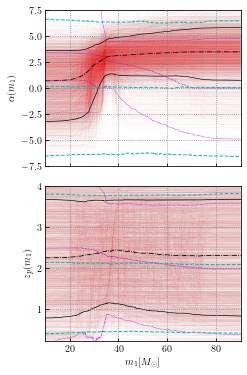

In [40]:
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9*cm, 2*6.75*cm))

new_masses = np.linspace(35, 120, 5000)

ax1.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.alpha_z.size):
    prior_alpha = rand.normal(0, 4)
    prior_high_alpha = rand.normal(0, 4)
    prior_width_alpha = rand.uniform(-1,1)
    prior_middle_alpha = rand.uniform(20, 75)
    posterior_value_m_35 = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               35,
                              )
    intermediate_step = 1 + np.exp(-1*(35. - samps.middle_m_alpha_z.values[i])/samps.width_alpha_z.values[i])
    value_at_m_35 = samps.alpha_z.values[i] + (
        (samps.high_alpha_z.values[i] - samps.alpha_z.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(-1*(35-prior_middle_alpha)/(10**(prior_width_alpha)))
    low_z_value_alpha = (prior_high_alpha - (value_at_m_35*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_alpha
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # ax1.plot(masses, alpha_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    
    alpha_r_post = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               masses,
                              )
    ax1.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
ax1.set_ylim(-7.5, 7.5)
ax1.set_ylabel(r"$\alpha(m_1)$", fontsize = 10)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.1,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.9,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax1.plot(masses,np.nanquantile(alpha_matrix,0.1,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax1.plot(masses,np.nanquantile(alpha_matrix,0.9,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax1.plot(masses, only_prior_alpha_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


ax2.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
zp_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.low_zp.size):
    prior_zp = rand.uniform(0.2, 4)
    prior_high_zp = rand.uniform(0.2, 4)
    prior_width_zp = rand.uniform(-1,1)
    prior_middle_zp = rand.uniform(20, 75)
    posterior_value_z_0 = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               35,
                              )
    intermediate_step = 1 + np.exp((samps.middle_m_zp.values[i] - 35.)/samps.width_zp.values[i])
    value_at_z_0 = samps.low_zp.values[i] + (
        (samps.high_zp.values[i] - samps.low_zp.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp((prior_middle_zp-35)/(10**(prior_width_zp)))
    low_z_value_zp = (prior_high_zp - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_zp
    zp_r = sigmoid_zp(low_z_value_zp,
                               prior_high_zp,
                               10.**prior_width_zp,
                               prior_middle_zp,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', zp = 0.2, zorder = 1)
    zp_matrix[i, :] = zp_r
    
    zp_r_post = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               masses,
                              )
    plt.plot(masses, zp_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    zp_matrix_post[i, :] = zp_r_post

median_zp = np.nanmedian(zp_matrix, axis = 0)
median_zp_post = np.median(zp_matrix_post, axis = 0)
ax2.set_xlim(10,90)
ax2.set_ylim(0.2, 4)
ax2.set_xlabel(r"$m_1 [M_\odot]$", fontsize = 10)
ax2.set_ylabel(r"$z_p(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax2.plot(masses, median_zp_post, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(masses,np.quantile(zp_matrix_post,0.1,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses,np.quantile(zp_matrix_post,0.9,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses, median_zp, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax2.plot(masses,np.nanquantile(zp_matrix,0.1,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax2.plot(masses,np.nanquantile(zp_matrix,0.9,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax2.plot(masses, only_prior_zp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

plt.setp(ax1.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("Reverse_conditional_plot_gauged_at_m_35.pdf", dpi=500, bbox_inches="tight")
plt.show()

In [39]:
print(median_alpha, alpha_matrix, np.nanquantile(alpha_matrix,0.1,axis=0), np.nanquantile(alpha_matrix,0.9,axis=0))
print(median_zp, zp_matrix, np.nanquantile(zp_matrix,0.1,axis=0), np.nanquantile(zp_matrix,0.9,axis=0))

[3.41051602 3.41051602 3.41051602 ... 0.         0.         0.        ] [[ 3.79951787e+00  3.79951787e+00  3.79951787e+00 ... -4.21410465e+00
  -4.21411228e+00 -4.21412086e+00]
 [ 2.72107887e+00  2.72107887e+00  2.72107887e+00 ...  2.88889313e+00
   2.88889313e+00  2.88889313e+00]
 [ 4.07044050e+14  4.07044050e+14  4.07044050e+14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.07607355e+01  1.07595892e+01  1.07584400e+01 ...  7.42304802e-01
   7.42304802e-01  7.42304802e-01]
 [ 1.46157742e+00  1.46157742e+00  1.46157742e+00 ... -1.04639988e+01
  -1.04639988e+01 -1.04639988e+01]
 [ 6.54712384e+08  6.54712384e+08  6.54712384e+08 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]] [ 0.76828395  0.76828395  0.76828395 ... -4.74444084 -4.74455223
 -4.74466286] [730.77435303 730.77316895 730.77203369 ...   5.20895233   5.20895481
   5.20895739]
[2.46340322 2.46340322 2.46340322 ... 1.95638359 1.95638359 1.95638359] [[2.10509658e+00 2.10509658e+00 2.10509658e+00 ... 1.229

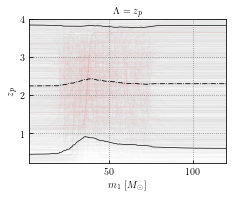

In [6]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))
for i in range(samps.alpha_ref.size):
    zp = sigmoid_zp(samps.low_zp.values[i], samps.high_zp.values[i], 10.**samps.log_width_zp.values[i], samps.middle_m_zp.values[i], m_grid)
    ax.plot(m_grid, zp, color='#e31a1c', lw=0.05, alpha = 0.1, zorder = 1)
    zp_matrix[i, :] = zp
    
median_zp = np.median(zp_matrix, axis = 0)
    
ax.set_xlim(2,120)
ax.set_ylim(0.2,4)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax.set_ylabel(r"$z_p$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.plot(m_grid, median_zp, "-.", c="k", zorder = 1, lw = 0.8)
ax.plot(m_grid,np.quantile(zp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax.plot(m_grid,np.quantile(zp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = z_p$", fontsize = 10)
plt.savefig("Trace_zp_reverse.pdf", dpi = 400, bbox_inches = "tight")
plt.show()

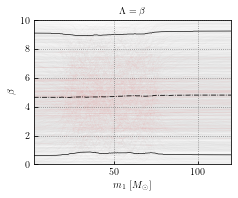

In [7]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
beta_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))
for i in range(samps.alpha_ref.size):
    zp = sigmoid_zp(samps.beta_z.values[i], samps.high_beta_z.values[i], 10.**samps.width_beta_z.values[i], samps.middle_m_beta_z.values[i], m_grid)
    ax.plot(m_grid, zp, color='#e31a1c', lw=0.05, alpha = 0.1, zorder = 1)
    beta_matrix[i, :] = zp
    
median_beta = np.median(beta_matrix, axis = 0)

ax.set_xlim(2,120)
ax.set_ylim(0,10)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax.set_ylabel(r"$\beta$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.plot(m_grid, median_beta, "-.", c="k", zorder = 1, lw = 0.8)
ax.plot(m_grid,np.quantile(beta_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax.plot(m_grid,np.quantile(beta_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = \beta$", fontsize = 10)
plt.savefig("Trace_beta_reverse.pdf", dpi = 400, bbox_inches = "tight")
plt.show()

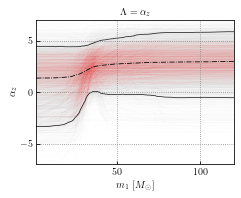

In [10]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))
for i in range(samps.alpha_ref.size):
    zp = sigmoid_zp(samps.alpha_z.values[i], samps.high_alpha_z.values[i], 10.**samps.width_alpha_z.values[i], samps.middle_m_alpha_z.values[i], m_grid)
    ax.plot(m_grid, zp, color='#e31a1c', lw=0.05, alpha = 0.1, zorder = 1)
    alpha_matrix[i, :] = zp
    
median_alpha = np.median(alpha_matrix, axis = 0)
ax.set_xlim(2,120)
ax.set_ylim(-7,7)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax.set_ylabel(r"$\alpha_z$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.plot(m_grid, median_alpha, "-.", c="k", zorder = 1, lw = 0.8)
ax.plot(m_grid,np.quantile(alpha_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax.plot(m_grid,np.quantile(alpha_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = \alpha_z$", fontsize = 10)
plt.savefig("Trace_alpha_reverse.pdf", dpi = 400, bbox_inches = "tight")
plt.show()